# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

## 1. Dati utilizzati

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [238]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [239]:
def get_stock_data(ticker, start_date, end_date):
    
    data_dir = "StockData" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def load_from_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            df = df.loc[start_date:end_date]
            return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def download_from_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = load_from_csv()
    
    if data is None or data.empty:
        data = download_from_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti ed inseriamoli in un DataFrame indicizzato per titolo e data.

In [240]:
start = dt.datetime(2014,5,31)
end = dt.datetime(2024,5,31)

tickers = ['AAPL', 'INTC', 'AMZN', 'WMT', 'V', 'MA']
data_frames = []

for ticker in tickers:
    df = get_stock_data(ticker, start, end)
    df['Ticker'] = ticker
    data_frames.append(df)
    
dataframe_completo = pd.concat(data_frames)
dataframe_completo.set_index(['Ticker', dataframe_completo.index], inplace=True)
dataframe_completo.sort_index(inplace=True)

dataframe_completo

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
AAPL   2014-06-02  22.641430  22.672501  22.232143  22.451786  19.859398   
       2014-06-03  22.445000  22.812143  22.437500  22.769285  20.140236   
       2014-06-04  22.765715  23.138929  22.718214  23.029285  20.370214   
       2014-06-05  23.078571  23.191786  22.950357  23.119642  20.450140   
       2014-06-06  23.210714  23.259287  23.016787  23.056070  20.393904   
...                      ...        ...        ...        ...        ...   
WMT    2024-05-23  65.169998  65.519997  64.559998  64.839996  64.839996   
       2024-05-24  65.129997  65.690002  65.010002  65.379997  65.379997   
       2024-05-28  65.220001  65.470001  64.739998  65.040001  65.040001   
       2024-05-29  64.750000  65.209999  64.650002  64.919998  64.919998   
       2024-05-30  64.930000  65.169998  64.769997  64.889999  64.889999   

                      Volume  
Ticker Date                   
AAPL   2014-06-02  369350800  
       2014-06-03  292709200  
       2014-06-04  335482000  
       2014-06-05  303805600  
       2014-06-06  349938400  
...                      ...  
WMT    2024-05-23   16222900  
       2024-05-24   11793800  
       2024-05-28   13349600  
       2024-05-29   11538600  
       2024-05-30   13053500  

[15102 rows x 6 columns]

In [241]:
prezzi_chiusura_giornalieri = dataframe_completo.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
prezzi_chiusura_giornalieri

Ticker,AAPL,AMZN,INTC,MA,V,WMT
Date,,,,,,
2014-06-02,19.859398,15.442000,20.772066,72.443565,49.775650,20.799509
2014-06-03,20.140236,15.359500,21.076870,71.785408,49.262760,20.785961
2014-06-04,20.370214,15.339000,21.031145,71.757202,49.288418,20.899773
2014-06-05,20.450140,16.178499,21.076870,72.246124,49.472580,20.951252
2014-06-06,20.393904,16.483500,21.465481,72.838463,49.654419,20.921448
...,...,...,...,...,...,...
2024-05-23,186.880005,181.050003,30.080000,451.209991,274.230011,64.839996
2024-05-24,189.979996,180.750000,30.719999,451.179993,274.489990,65.379997
2024-05-28,189.990005,182.149994,31.059999,445.079987,270.980011,65.040001


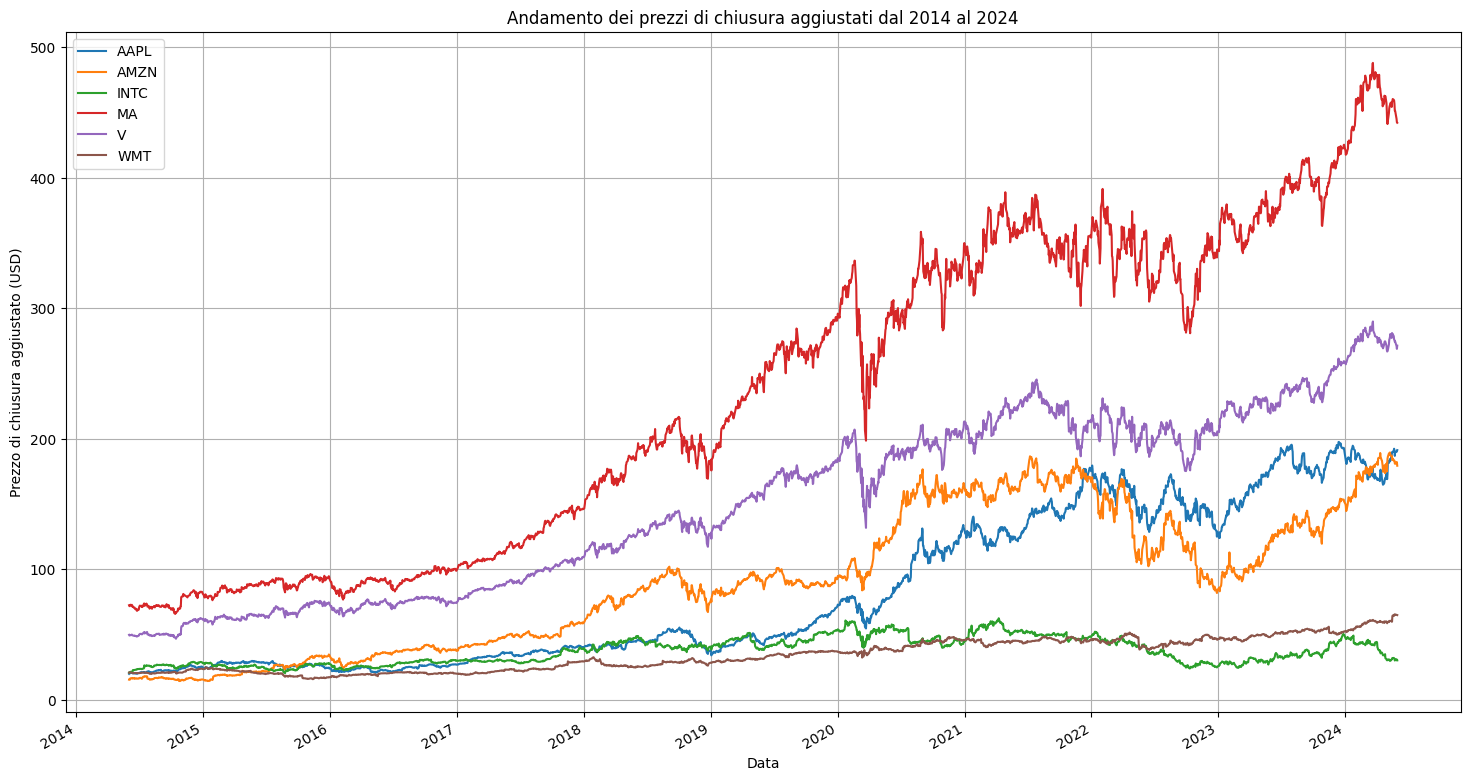

In [242]:
prezzi_chiusura_giornalieri.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Statistiche descrittive

Calcoliamo il rendimento cumulato per ciascun titolo.

In primis definiamo una funzione che ci consenta di rappresentare i grafici di ciascun titolo in maniera separata, per evitare di fare confusione.

In [243]:
# Per creare i grafici utilizzo la mappa dei colori predefinita di matplotlib: in questo modo, ogni ticker mantiene il proprio colore nei diversi grafici
color_map = plt.get_cmap('tab10') 

def crea_grafici_separati(dataframe, label):
    # Itera attraverso i tickers e genera un grafico separato per ciascuno di essi
    for i, ticker in enumerate(tickers):
        
        # Seleziona solo i dati relativi al ticker corrente
        data = dataframe[ticker]

        # Crea il grafico con un colore diverso dalla mappa dei colori
        plt.figure(figsize=(12, 8))  
        plt.plot(data.index, data, label=ticker, color=color_map(i))  
        plt.title(f'{ticker}')  
        plt.xlabel('Data')  
        plt.ylabel(label) 
        plt.legend() 
        plt.grid(True)
        plt.show()

A partire dal DataFrame contenente i prezzi di chiusura giornalieri andiamo a ricavare i rendimenti netti e lordi.

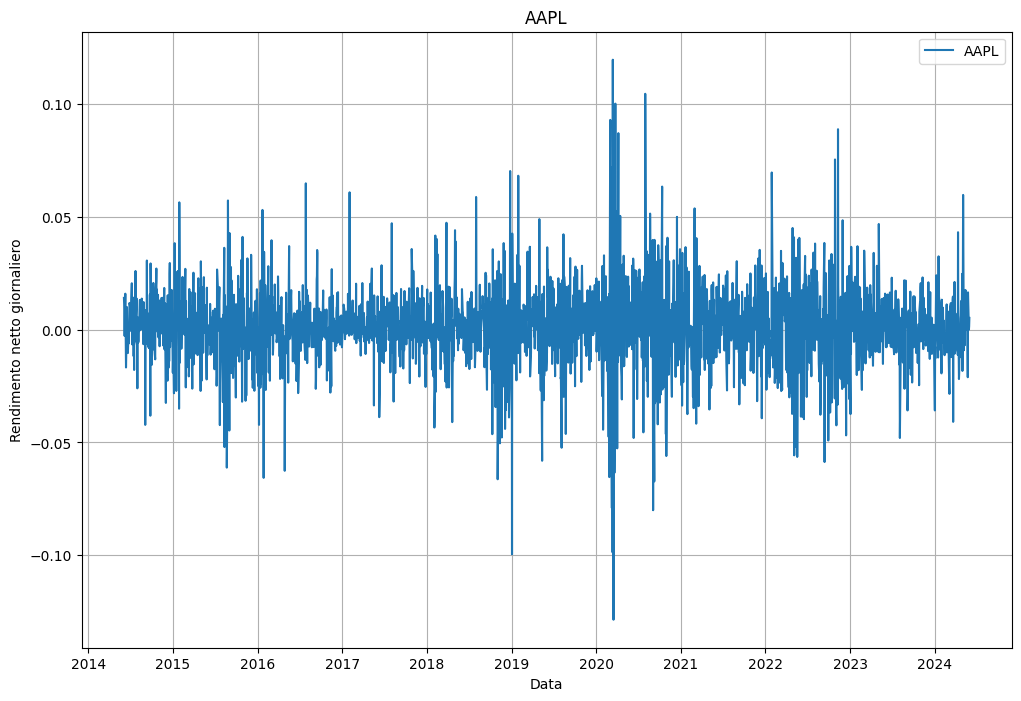

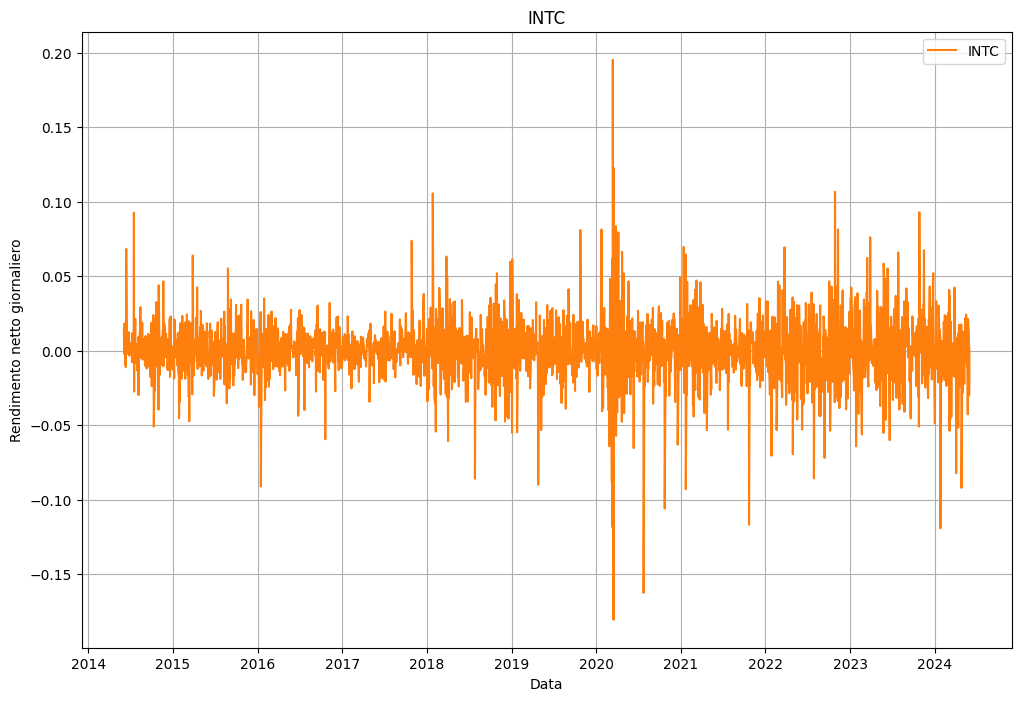

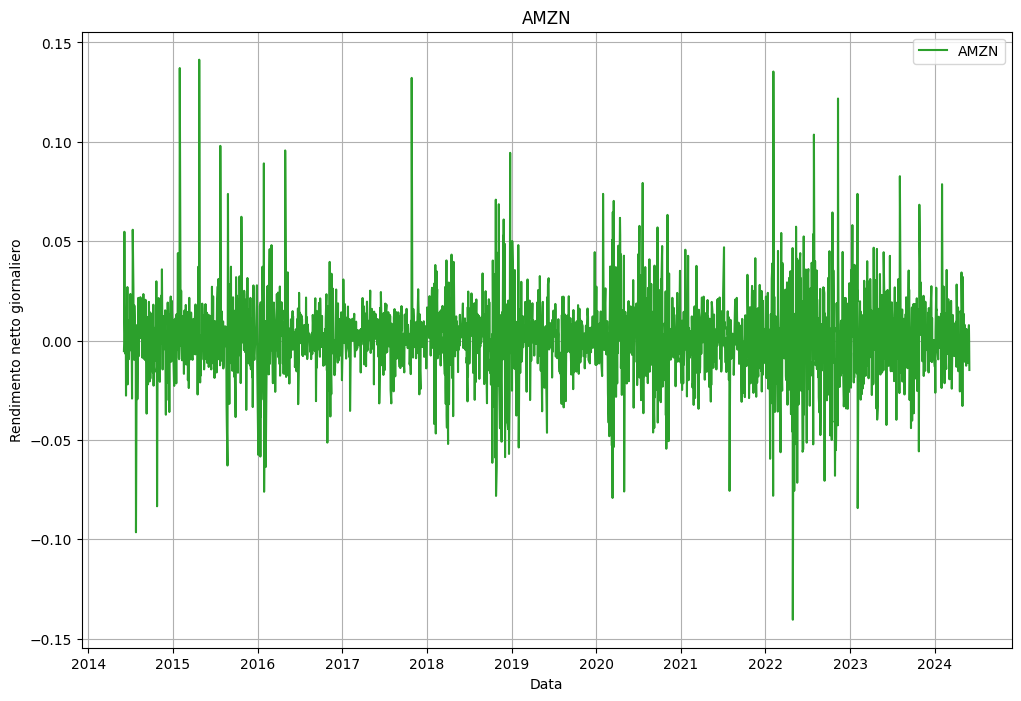

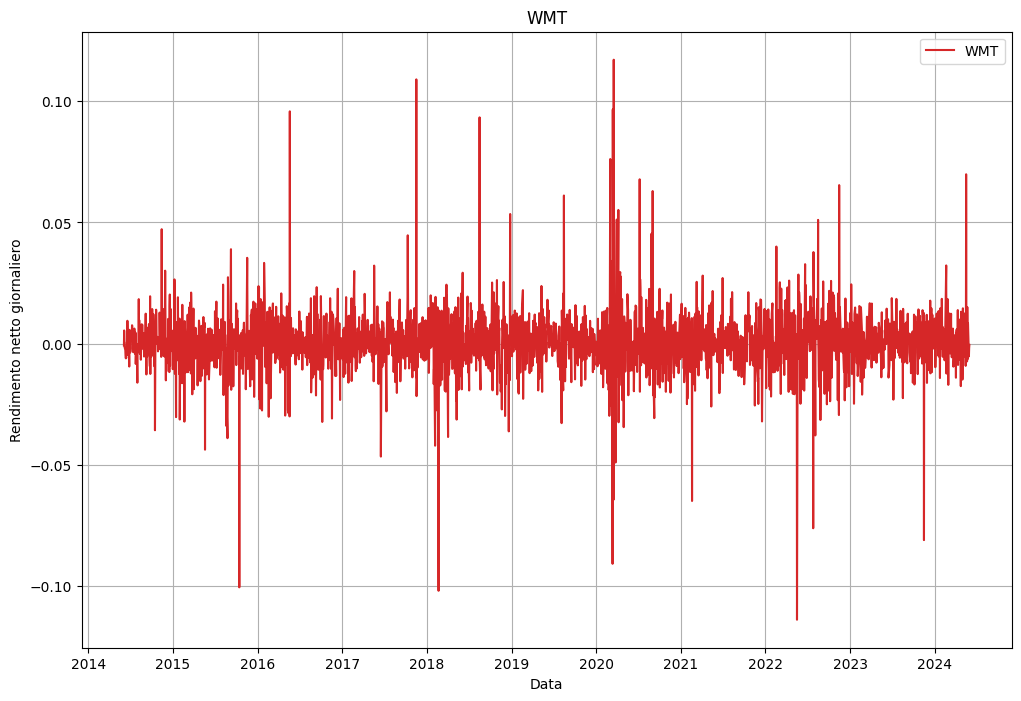

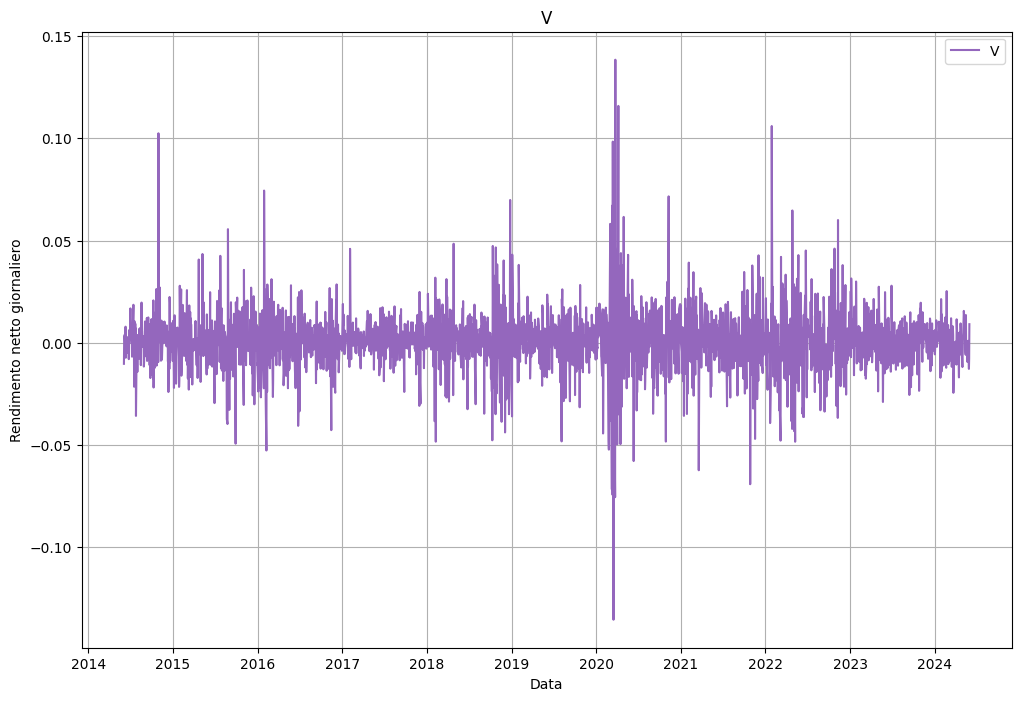

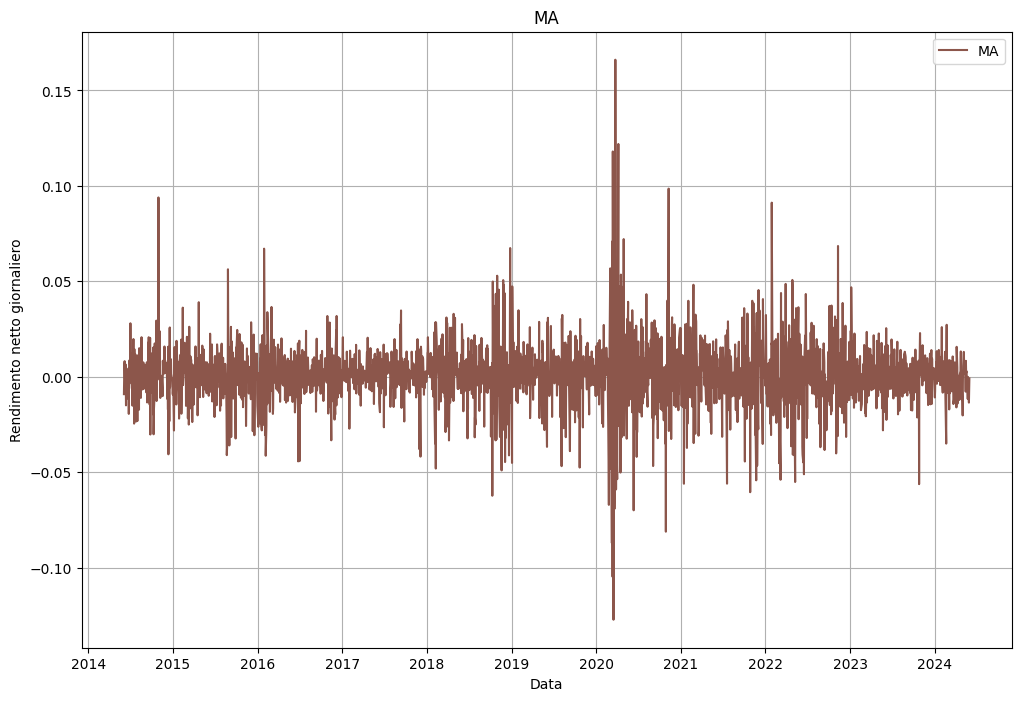

In [244]:
# calcolo i rendimenti netti (come variazione di prezzo giornaliera) e rimuovo i NaN
rendimenti_netti_giornalieri = prezzi_chiusura_giornalieri.pct_change().dropna()

crea_grafici_separati(rendimenti_netti_giornalieri, 'Rendimento netto giornaliero')

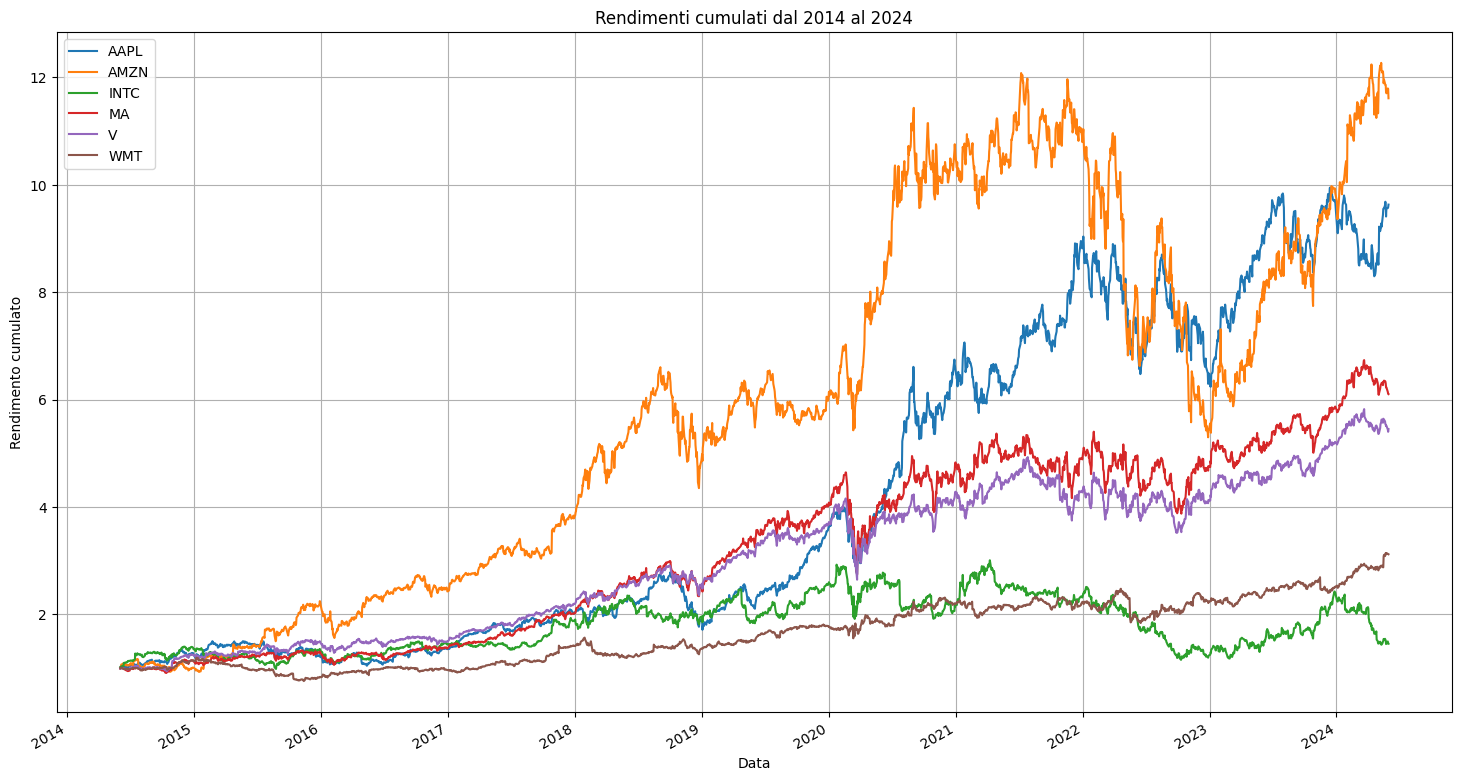

In [245]:
# ricavo i rendimenti lordi a partire da quelli netti
rendimenti_lordi_giornalieri = rendimenti_netti_giornalieri + 1

# calcolo i rendimenti cumulati come prodotto cumulativo dei rendimenti lordi
rendimenti_cumulati = rendimenti_lordi_giornalieri.cumprod()

rendimenti_cumulati.plot(figsize=(18, 10))
plt.title('Rendimenti cumulati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Rendimento cumulato')
plt.legend()
plt.grid(True)
plt.show()